In [3]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 670.6 kB/s eta 0:00:00


In [5]:
import torch
import numpy as np
import librosa
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error
from scipy.io.wavfile import write
import torch.nn as nn
import matplotlib.pyplot as plt
from einops import rearrange
from PIL import Image
import torchvision
from sklearn import preprocessing

In [6]:
from sklearn.kernel_approximation import RBFSampler

In [10]:
image = torchvision.io.read_image("IMG.jpg")
print(image.shape) # Resize for faster computation
img_array = np.array(image) / 255.0
image = torchvision.transforms.functional.crop(image.cpu(), 600, 800, 300, 300)
print(image.shape)

torch.Size([3, 1365, 2048])
torch.Size([3, 300, 300])


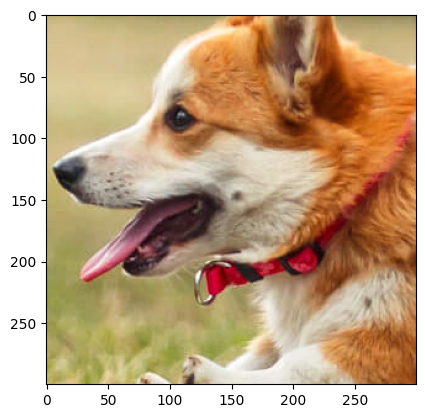

In [11]:
plt.imshow(rearrange(image, "c h w -> h w c").numpy())

In [12]:
scaler_img = preprocessing.MinMaxScaler().fit(image.reshape(-1, 1))
img_scaled = scaler_img.transform(image.reshape(-1, 1)).reshape(image.shape)
img_scaled.shape
img_scaled = torch.tensor(img_scaled)
img_scaled

tensor([[[0.7686, 0.7686, 0.7686,  ..., 0.5451, 0.5451, 0.5412],
         [0.7725, 0.7725, 0.7725,  ..., 0.5686, 0.5686, 0.5647],
         [0.7765, 0.7765, 0.7765,  ..., 0.5882, 0.5843, 0.5843],
         ...,
         [0.7961, 0.7373, 0.7176,  ..., 0.5843, 0.5725, 0.5490],
         [0.8471, 0.7843, 0.7451,  ..., 0.6039, 0.5686, 0.5569],
         [0.8784, 0.8196, 0.7686,  ..., 0.6275, 0.5804, 0.5686]],

        [[0.6941, 0.6941, 0.6941,  ..., 0.5137, 0.5137, 0.5098],
         [0.6980, 0.6980, 0.6980,  ..., 0.5255, 0.5255, 0.5216],
         [0.7020, 0.7020, 0.7020,  ..., 0.5451, 0.5412, 0.5412],
         ...,
         [0.7686, 0.7098, 0.6863,  ..., 0.2824, 0.2706, 0.2431],
         [0.8157, 0.7569, 0.7137,  ..., 0.3059, 0.2667, 0.2431],
         [0.8431, 0.7882, 0.7333,  ..., 0.3294, 0.2706, 0.2588]],

        [[0.4745, 0.4745, 0.4745,  ..., 0.3294, 0.3294, 0.3255],
         [0.4784, 0.4784, 0.4784,  ..., 0.3451, 0.3451, 0.3412],
         [0.4824, 0.4824, 0.4824,  ..., 0.3647, 0.3608, 0.

In [13]:
def create_coordinate_map(img):

    num_channels,width, height = img.shape

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)



    X = torch.stack([h_coords, w_coords], dim = 1).float()
    Y = rearrange(img, 'c h w -> (h w) c')

    return X, Y

In [14]:
dog_X, dog_Y = create_coordinate_map(img_scaled)
dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [15]:
dog_X,dog_Y

(tensor([[  0.,   0.],
         [  0.,   1.],
         [  0.,   2.],
         ...,
         [299., 297.],
         [299., 298.],
         [299., 299.]]),
 tensor([[0.7686, 0.6941, 0.4745],
         [0.7686, 0.6941, 0.4745],
         [0.7686, 0.6941, 0.4745],
         ...,
         [0.6275, 0.3294, 0.0863],
         [0.5804, 0.2706, 0.0392],
         [0.5686, 0.2588, 0.0392]], dtype=torch.float64))

In [16]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled

array([[-1.        , -1.        ],
       [-1.        , -0.99331104],
       [-1.        , -0.98662207],
       ...,
       [ 1.        ,  0.98662207],
       [ 1.        ,  0.99331104],
       [ 1.        ,  1.        ]])

In [17]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [18]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, features)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [19]:
def predict_plot(original_img, net, X, removed_img, giveMetrics = False, allowSave = False, fileName1 = None, fileName2 = None):
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    rmse, psnr = metrics(original_img, rearrange(outputs, "h w c -> c h w"))

    fig, ax = plt.subplots(nrows = 1, ncols = 3, gridspec_kw = {"width_ratios": [1, 1, 1]}, figsize = (13, 6))
    fig.suptitle(f"Reconstruction using RFF" "\n" f"RMSE : {rmse} | PSNR : {psnr}", fontsize = 10)
    ax[0].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title(fr"Ground Truth Image $({height} \times {width})$")
    ax[0].axis("off")
    ax[1].imshow(rearrange(removed_img, 'c h w -> h w c').cpu().numpy())
    ax[1].set_title(fr"Removed Points Image")
    ax[1].axis("off")
    ax[2].imshow(outputs.cpu().detach().numpy())
    ax[2].set_title(fr"Reconstructed Image $({height} \times {width})$")
    ax[2].axis("off")

    if allowSave and fileName1 and fileName2:
      save_reconstructed_image(outputs, fileName1)
      save_reconstructed_image(rearrange(removed_img, 'c h w -> h w c'), fileName2)

    plt.show()

    if giveMetrics:
      return rmse, psnr

In [20]:
def create_rff_features(X, num_features, sigma):
  rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state = 42)
  X = rff.fit_transform(X)
  return torch.tensor(X, dtype=torch.float32)

In [21]:
X_rff = create_rff_features(dog_X_scaled, 15000, 0.008)

In [22]:
X_rff.shape

torch.Size([90000, 15000])

In [27]:
def remove_patch(img, Corner, d, display = True):
    X, Y = Corner
    # latexify(columns = 2, fig_width = 10)
    img_copy = img.clone()
    img_copy[:, X : X + d, Y : Y + d] = float("nan")
    crop = torchvision.transforms.functional.crop(img.cpu(), X, Y, d, d)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, gridspec_kw = {"width_ratios": [img.shape[2] / (5 * d), 1]})
    fig.suptitle(fr"Patch size = $({d} \times {d})$ removed", fontsize = 16)
    ax[0].imshow(rearrange(img_copy, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title("Masked Image")
    ax[1].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
    ax[1].set_title("Masked Crop")
    if (display):
        plt.show()
    else:
        plt.close()
    return img_copy, crop

In [35]:
def metrics(img1, img2, max_value = 1.0):
  rmse = torch.sqrt(F.mse_loss(img1, img2))
  psnr_value = 20 * torch.log10(max_value / rmse)
  return rmse, psnr_value.item()

In [38]:
import torch.nn.functional as F

In [36]:
def predict_plot(original_img, net, X, removed_img, giveMetrics = False, allowSave = False, fileName1 = None, fileName2 = None):
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)

    rmse, psnr = metrics(original_img, rearrange(outputs, "h w c -> c h w"))

    fig, ax = plt.subplots(nrows = 1, ncols = 3, gridspec_kw = {"width_ratios": [1, 1, 1]}, figsize = (13, 6))
    fig.suptitle(f"Reconstruction using RFF" "\n" f"RMSE : {rmse} | PSNR : {psnr}", fontsize = 10)
    ax[0].imshow(rearrange(original_img, 'c h w -> h w c').cpu().numpy())
    ax[0].set_title(fr"Ground Truth Image $({height} \times {width})$")
    ax[0].axis("off")
    ax[1].imshow(rearrange(removed_img, 'c h w -> h w c').cpu().numpy())
    ax[1].set_title(fr"Removed Points Image")
    ax[1].axis("off")
    ax[2].imshow(outputs.cpu().detach().numpy())
    ax[2].set_title(fr"Reconstructed Image $({height} \times {width})$")
    ax[2].axis("off")

    # if allowSave and fileName1 and fileName2:
    #   save_reconstructed_image(outputs, fileName1)
    #   save_reconstructed_image(rearrange(removed_img, 'c h w -> h w c'), fileName2)

    plt.show()

    if giveMetrics:
      return rmse, psnr

In [33]:
net = LinearModel(15000, 3)
left_image, _ = remove_patch(img_scaled, (200, 115), 30, display=False)

# Convert to float32
mask = rearrange(~torch.isnan(left_image)[0], "h w -> (h w)")
X_rff_float = X_rff[mask].float()  # Convert to float32
dog_Y_float = dog_Y[mask].float()  # Convert to float32

train(net, 0.01, X_rff_float, dog_Y_float, 2000, verbose=True)


Epoch 0 loss: 0.370504
Epoch 100 loss: 0.015649
Epoch 200 loss: 0.007987
Epoch 300 loss: 0.004611
Epoch 400 loss: 0.002857
Epoch 500 loss: 0.001908
Epoch 600 loss: 0.001377
Epoch 700 loss: 0.001067
Epoch 800 loss: 0.000879
Epoch 900 loss: 0.000760
Epoch 1000 loss: 0.000680
Epoch 1100 loss: 0.000626
Epoch 1200 loss: 0.000587
Epoch 1300 loss: 0.000558
Epoch 1400 loss: 0.000537
Epoch 1500 loss: 0.000521
Epoch 1600 loss: 0.000509
Epoch 1700 loss: 0.000499
Epoch 1800 loss: 0.000492
Epoch 1900 loss: 0.000486


NameError: name 'metrics' is not defined

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


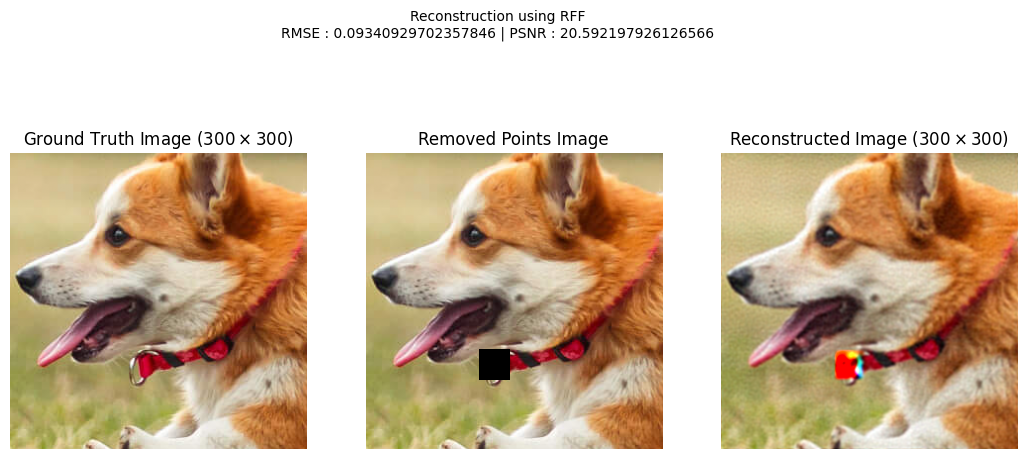

In [39]:
rmse, psnr = predict_plot(img_scaled, net, X_rff, left_image, giveMetrics=True, allowSave=True, fileName1=f"./ReconstructPatch.png", fileName2=f"./EmptyPatch.png")


In [ ]:
audio_path = 'sample.wav'
audio, sr = librosa.load(audio_path, sr=22050, duration=5)

# Normalize audio
audio = audio / np.max(np.abs(audio))

In [ ]:
# Create time points corresponding to the audio signal
t = np.linspace(0, len(audio) / sr, len(audio)).reshape(-1, 1)

# Amplitudes are the audio signal values
A = audio.reshape(-1, 1)

# Convert to torch tensors
X = torch.tensor(t, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')
Y = torch.tensor(A, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def create_rff_features(X, num_features, sigma):
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X_np = X.cpu().numpy()
    X_transformed = rff.fit_transform(X_np)
    return torch.tensor(X_transformed, dtype=torch.float32).to(X.device)

# Generate RFF features
num_features = 1500
X_rff = create_rff_features(X, num_features, sigma=0.005)


In [ ]:
class SimpleLinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleLinearModel, self).__init__()
        self.fc1 = nn.Linear(in_features, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = SimpleLinearModel(X_rff.shape[1], 1).to(X.device)


In [ ]:
def train(model, X, Y, lr=0.001, epochs=1000):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

train(model, X_rff, Y, lr=0.001, epochs=3000)


Epoch 0, Loss: 0.020549
Epoch 500, Loss: 0.001624
Epoch 1000, Loss: 0.001031
Epoch 1500, Loss: 0.000718
Epoch 2000, Loss: 0.000561
Epoch 2500, Loss: 0.000479


SimpleLinearModel(
  (fc1): Linear(in_features=1500, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
def reconstruct_audio(model, X):
    model.eval()
    with torch.no_grad():
        reconstructed_audio = model(X).cpu().numpy()
    return reconstructed_audio

# Reconstruct the audio
reconstructed_audio = reconstruct_audio(model, X_rff).flatten()


In [ ]:
# RMSE
rmse = np.sqrt(mean_squared_error(audio, reconstructed_audio))
print(f"RMSE: {rmse:.6f}")

# SNR calculation
def snr(original, reconstructed):
    signal_power = np.mean(original ** 2)
    noise_power = np.mean((original - reconstructed) ** 2)
    return 10 * np.log10(signal_power / noise_power)

snr_value = snr(audio, reconstructed_audio)
print(f"SNR: {snr_value:.6f} dB")


RMSE: 0.027778
SNR: 13.607687 dB


In [ ]:
# Save original and reconstructed audio for playback
write("original_audio.wav", sr, audio)
write("reconstructed_audio.wav", sr, reconstructed_audio)


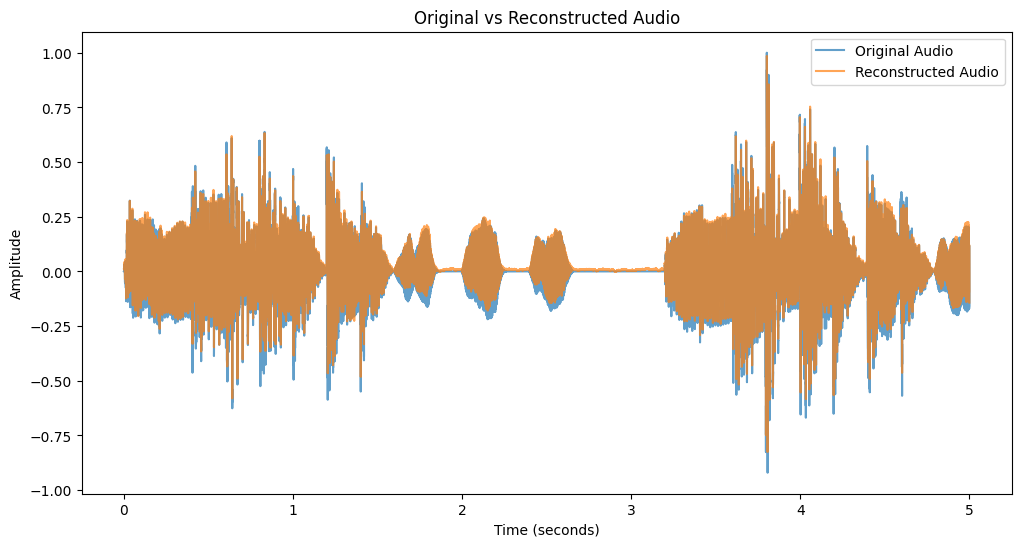

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t, audio, label='Original Audio', alpha=0.7)
plt.plot(t, reconstructed_audio, label='Reconstructed Audio', alpha=0.7)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio')
plt.legend()
plt.show()


In [ ]:
from IPython.display import Audio, display
import soundfile as sf

# Save audio files
sf.write("original_audio.wav", audio, sr)
sf.write("reconstructed_audio.wav", reconstructed_audio, sr)

# Display and play the audio files in the notebook
print("Original Audio:")
display(Audio("original_audio.wav"))

print("Reconstructed Audio:")
display(Audio("reconstructed_audio.wav"))


Original Audio:


Reconstructed Audio:
